# Import all Necessary Packages

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# sklearn utilities
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, plot_roc_curve
from sklearn.preprocessing import label_binarize

# sklearn models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from itertools import chain

#from sklearn.linear_model import LogisticRegressionCV
#from sklearn.model_selection import cross_val_score, train_test_split
import tensorflow as tf

# Data Preprocessing

In [2]:
# read in JSON files
data_freq = pd.read_json('storywrangler_data_freq.json')
data_rank = pd.read_json('storywrangler_data_rank.json')

In [3]:
idx_vals = data_freq.index.tolist()
# extract the names of the foods from the indices
foods = idx_vals[4:]

print(foods)

# initialize lists
date_list = []
freq_list = []
rank_list = []
food_list = []

# iterate through each food to extract data and append 
# it to associated list
for food in foods:
    d_mat = data_freq.loc[food,'data']
    rank_mat = data_rank.loc[food,'data']
    for i in range(len(d_mat)):
        date_list.append(d_mat[i][0])
        freq_list.append(d_mat[i][1])
        rank_list.append(rank_mat[i][1])
        food_list.append(food)

# turn the lists into a data frame
data = pd.DataFrame(data=date_list, columns=['Date'])
data['Freq'] = freq_list
data['Rank'] = rank_list
data['Food'] = food_list


data['Freq'] = data['Freq'].fillna(0)
data['Rank'] = data['Rank'].fillna(1000000)

data

['sardines', 'brussel sprouts', 'horseradish', 'pizza', 'ice cream', 'eggs']


,Date,Freq,Rank,Food
0,2009-08-01T00:00:00.000Z,7.801821e-07,40353.5,sardines
1,2009-08-02T00:00:00.000Z,9.496888e-07,34942.5,sardines
2,2009-08-03T00:00:00.000Z,9.491071e-07,36187.5,sardines
3,2009-08-08T00:00:00.000Z,5.019872e-07,57784.0,sardines
4,2009-08-09T00:00:00.000Z,5.552848e-07,52968.5,sardines
...,...,...,...,...
24828,2020-12-01T00:00:00.000Z,1.519798e-05,4903.5,eggs
24829,2020-12-02T00:00:00.000Z,1.692453e-05,4508.0,eggs
24830,2020-12-03T00:00:00.000Z,1.410875e-05,5166.5,eggs
24831,2020-12-04T00:00:00.000Z,1.302754e-05,5591.0,eggs


In [4]:
data['Freq'] = (data['Freq'] - data['Freq'].min()) / (data['Freq'].max() - data['Freq'].min())
data['Rank'] = (data['Rank'] - data['Rank'].min()) / (data['Rank'].max() - data['Rank'].min())

In [5]:
# determine if popular based off of the a chosen divide between datasets
is_popular = []

freq_thres = .02
rank_thres = .0125

for i in range(len(data)):
    freq_diff = data.iloc[i,1] - freq_thres
    rank_diff = -(data.iloc[i,2] - rank_thres)
    
    
    if (freq_diff >= 0) and (rank_diff >= 0):
        is_popular.append(1)
    elif (freq_diff < 0) and (rank_diff < 0):
        is_popular.append(0)
    elif abs(freq_diff) > abs(rank_diff):
        if (freq_diff >= 0):
            is_popular.append(1)
        else:
            is_popular.append(0)
    else:
        if (rank_diff >= 0):
            is_popular.append(1)
        else:
            is_popular.append(0)
        

data['Popular?'] = is_popular
data
        

,Date,Freq,Rank,Food,Popular?
0,2009-08-01T00:00:00.000Z,0.002399,0.040106,sardines,0
1,2009-08-02T00:00:00.000Z,0.002921,0.034693,sardines,0
2,2009-08-03T00:00:00.000Z,0.002919,0.035939,sardines,0
3,2009-08-08T00:00:00.000Z,0.001544,0.057541,sardines,0
4,2009-08-09T00:00:00.000Z,0.001708,0.052724,sardines,0
...,...,...,...,...,...
24828,2020-12-01T00:00:00.000Z,0.046738,0.004647,eggs,1
24829,2020-12-02T00:00:00.000Z,0.052048,0.004251,eggs,1
24830,2020-12-03T00:00:00.000Z,0.043388,0.004910,eggs,1
24831,2020-12-04T00:00:00.000Z,0.040063,0.005334,eggs,1


In [6]:
def calc_avg(df):    
    freq_avg = df.iloc[:,1].rolling(window=7).mean().tolist()
    rank_avg = df.iloc[:,2].rolling(window=7).mean().tolist()

    del freq_avg[0:6]
    del rank_avg[0:6]

    for i in range(1,8):
        freq_avg.insert(i-1,df.iloc[0:i,1].rolling(window=i).mean().tolist()[i-1])
        rank_avg.insert(i-1,df.iloc[0:i,2].rolling(window=i).mean().tolist()[i-1])
    return (freq_avg, rank_avg)

In [7]:
def calc_trending(df):
    is_trending = []
    delta_freq = []
    delta_rank = []
    
    avgs = calc_avg(df)

    for i in range(len(df)):
        freq_diff = df.iloc[i,1] - avgs[0][i]
        rank_diff = -(df.iloc[i,2] - avgs[1][i])

        delta_freq.append(freq_diff)
        delta_rank.append(rank_diff)

        if (freq_diff >= 0) and (rank_diff >= 0):
            is_trending.append(1)
        elif (freq_diff < 0) and (rank_diff < 0):
            is_trending.append(0)
        elif abs(freq_diff) > abs(rank_diff):
            if (freq_diff >= 0):
                is_trending.append(1)
            else:
                is_trending.append(0)
        else:
            if (rank_diff >= 0):
                is_trending.append(1)
            else:
                is_trending.append(0)

    print(is_trending)
    return (is_trending, delta_freq, delta_rank)

In [8]:
is_trending = []
delta_freq = []
delta_rank = []

for food in foods:
    is_trending.append(calc_trending(data[data['Food']==food])[0])
    delta_freq.append(calc_trending(data[data['Food']==food])[1])
    delta_rank.append(calc_trending(data[data['Food']==food])[2])

is_trending = list(chain.from_iterable(is_trending)) 
delta_freq = list(chain.from_iterable(delta_freq)) 
delta_rank = list(chain.from_iterable(delta_rank)); 

[1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 

[1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 

[1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 

[1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 

[1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 

[1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 

[1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 

In [9]:
data["trending?"] = is_trending
data['Delta Freq'] = delta_freq
data['Delta Rank'] = delta_rank

In [10]:
target = []


for i in range(len(data)):
    # not popular and not trending
    if (data.iloc[i,4] == 0) and (data.iloc[i,5] == 0):
        target.append(0)
    # not popular but is trending
    elif (data.iloc[i,4] == 0) and (data.iloc[i,5] == 1):
        target.append(1)
    # popular but not trending
    elif (data.iloc[i,4] == 1) and (data.iloc[i,5] == 0):
        target.append(2)
    # popular and trending
    elif (data.iloc[i,4] == 1) and (data.iloc[i,5] == 1):
        target.append(3)
    else:
        print("ERROR")
        
data['Target'] = target
data

,Date,Freq,Rank,Food,Popular?,trending?,Delta Freq,Delta Rank,Target
0,2009-08-01T00:00:00.000Z,0.002399,0.040106,sardines,0,1,0.000000,-0.000000,1
1,2009-08-02T00:00:00.000Z,0.002921,0.034693,sardines,0,1,0.000261,0.002706,1
2,2009-08-03T00:00:00.000Z,0.002919,0.035939,sardines,0,1,0.000173,0.000974,1
3,2009-08-08T00:00:00.000Z,0.001544,0.057541,sardines,0,0,-0.000902,-0.015471,0
4,2009-08-09T00:00:00.000Z,0.001708,0.052724,sardines,0,0,-0.000590,-0.008523,0
...,...,...,...,...,...,...,...,...,...
24828,2020-12-01T00:00:00.000Z,0.046738,0.004647,eggs,1,0,-0.005380,-0.000295,2
24829,2020-12-02T00:00:00.000Z,0.052048,0.004251,eggs,1,1,0.000119,0.000122,3
24830,2020-12-03T00:00:00.000Z,0.043388,0.004910,eggs,1,0,-0.009387,-0.000600,2
24831,2020-12-04T00:00:00.000Z,0.040063,0.005334,eggs,1,0,-0.010653,-0.000879,2


In [11]:
# just to show it's working
data[data['Target']==2]

,Date,Freq,Rank,Food,Popular?,trending?,Delta Freq,Delta Rank,Target
12409,2009-08-03T00:00:00.000Z,0.198476,0.001095,pizza,1,0,-0.056250,-0.000249,2
12410,2009-08-07T00:00:00.000Z,0.237040,0.000885,pizza,1,0,-0.013265,-0.000029,2
12411,2009-08-08T00:00:00.000Z,0.249315,0.000832,pizza,1,0,-0.000791,0.000019,2
12414,2009-08-11T00:00:00.000Z,0.209206,0.001017,pizza,1,0,-0.047714,-0.000192,2
12415,2009-08-12T00:00:00.000Z,0.211383,0.001006,pizza,1,0,-0.037035,-0.000144,2
...,...,...,...,...,...,...,...,...,...
24827,2020-11-30T00:00:00.000Z,0.041828,0.005119,eggs,1,0,-0.010357,-0.000788,2
24828,2020-12-01T00:00:00.000Z,0.046738,0.004647,eggs,1,0,-0.005380,-0.000295,2
24830,2020-12-03T00:00:00.000Z,0.043388,0.004910,eggs,1,0,-0.009387,-0.000600,2
24831,2020-12-04T00:00:00.000Z,0.040063,0.005334,eggs,1,0,-0.010653,-0.000879,2


In [12]:
features = data.loc[:,['Freq','Rank','Delta Freq','Delta Rank']]
target = data.loc[:,'Target']

# spilt into testing and training sets
X_train, X_test, y_train, y_test = train_test_split(features,target,test_size=0.25, random_state=0)

print(y_test)

5284     0
4630     0
9944     0
8719     1
17489    2
        ..
22268    3
8019     1
3331     1
20893    3
20670    3
Name: Target, Length: 6209, dtype: int64


# Models

## Support Vector Machine

In [13]:
svm = SVC()
svm.fit(X_train,y_train)
y_predictsvm = svm.predict(X_test)

In [14]:
#make confusion matrix for svm and make it a pandas dataframe
cm1 = confusion_matrix(y_test,y_predictsvm)
cm_df1 = pd.DataFrame(data=cm1)

accuracy_svm = accuracy_score(y_test,y_predictsvm)

print(cm_df1)
print('accuracy is ',accuracy_svm)


      0     1     2     3
0  1355    61     0     0
1    11  1705     0     0
2     0     0  1691     0
3     0     0   139  1247
accuracy is  0.9660170719922693


## Decision Tree Classifier

In [15]:
#make decision tree classifier
dtc = DecisionTreeClassifier(splitter='random')
dtc.fit(X_train,y_train)
y_predict_dtc = dtc.predict(X_test)


In [16]:
accuracy_dtc = accuracy_score(y_test,y_predict_dtc)

cm2 = confusion_matrix(y_test,y_predict_dtc)
cm_df2 = pd.DataFrame(data=cm2)
print(cm_df2)
print('accuracy is ',accuracy_dtc)

      0     1     2     3
0  1382    34     0     0
1    16  1700     0     0
2     0     0  1683     8
3     0     0     8  1378
accuracy is  0.9893702689644065


## Logistic Regression

In [17]:
#create logistic regression model, train it, and get predicted values with it
lr = LogisticRegression()
lr.fit(X_train,y_train)
y_predict_lr = lr.predict(X_test)

In [18]:
#get confusion matrix, and convert it to a pandas dataframe
cm_lr = confusion_matrix(y_test,y_predict_lr)
cm_df_lr = pd.DataFrame(data=cm_lr)

accuracy_lr = accuracy_score(y_test,y_predict_lr)

print(cm_df_lr)
print('accuracy is ', accuracy_lr)

      0     1     2    3
0  1244   172     0    0
1     0  1716     0    0
2     0     0  1679   12
3     0     1   568  817
accuracy is  0.8787244322757288


## Random Forest

In [19]:
#create random forest model, train it, and get predicted values with it
rfc = RandomForestClassifier()
rfc.fit(X_train,y_train)
y_predict_rfc = rfc.predict(X_test)

In [20]:
#get confusion matrix, and convert it to a pandas dataframe
cm_rfc = confusion_matrix(y_test,y_predict_rfc)
cm_df_rfc = pd.DataFrame(data=cm_rfc)

accuracy_rfc = accuracy_score(y_test,y_predict_rfc)

print(cm_df_rfc)
print('accuracy is ', accuracy_rfc)

      0     1     2     3
0  1397    19     0     0
1     0  1716     0     0
2     0     0  1688     3
3     0     0     3  1383
accuracy is  0.9959735867289419


# Neural Network

In [21]:
from sklearn.neural_network import MLPClassifier

clf = MLPClassifier(hidden_layer_sizes=(8,),random_state=1, activation='relu', solver='adam', early_stopping=True).fit(X_train, y_train)
clf.predict_proba(X_test)
y_predict_nn = clf.predict(X_test)

In [22]:
cm_nn = confusion_matrix(y_test, y_predict_nn)
cm_df_nn = pd.DataFrame(data=cm_nn)
cm_df_nn

accuracy_nn = accuracy_score(y_test,y_predict_nn)

# Create Ensemble

In [23]:
results = pd.DataFrame(data=y_predict_nn,columns=['NN'])


results['DT'] = y_predict_dtc
results['LG'] = y_predict_lr
results['RF'] = y_predict_rfc
results['SVM'] = y_predictsvm

results

,NN,DT,LG,RF,SVM
0,0,0,0,0,0
1,0,0,0,0,0
2,0,0,0,0,0
3,1,1,1,1,1
4,2,2,2,2,2
...,...,...,...,...,...
6204,3,3,3,3,3
6205,1,1,1,1,1
6206,1,1,1,1,1
6207,3,3,3,3,3


# Calculate Results

In [24]:
final_prediction = results.mode(axis=1).iloc[:,0]
results['Prediction'] = final_prediction

results

,NN,DT,LG,RF,SVM,Prediction
0,0,0,0,0,0,0
1,0,0,0,0,0,0
2,0,0,0,0,0,0
3,1,1,1,1,1,1
4,2,2,2,2,2,2
...,...,...,...,...,...,...
6204,3,3,3,3,3,3
6205,1,1,1,1,1,1
6206,1,1,1,1,1,1
6207,3,3,3,3,3,3


In [25]:
accuracy = accuracy_score(y_test,final_prediction)
print(accuracy)

0.9843775165082944


In [26]:
cm_final = confusion_matrix(y_test,final_prediction)
cm_df = pd.DataFrame(data=cm_final)
cm_df

,0,1,2,3
0,1366,50,0,0
1,1,1715,0,0
2,0,0,1691,0
3,0,0,46,1340


In [27]:
class_report = classification_report(y_test,final_prediction)
print(class_report)

              precision    recall  f1-score   support

           0       1.00      0.96      0.98      1416
           1       0.97      1.00      0.99      1716
           2       0.97      1.00      0.99      1691
           3       1.00      0.97      0.98      1386

    accuracy                           0.98      6209
   macro avg       0.99      0.98      0.98      6209
weighted avg       0.98      0.98      0.98      6209



Text(0, 0.5, 'Accuracy')

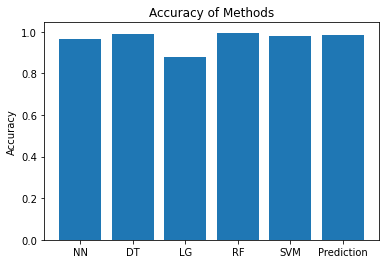

In [28]:
accuracy_array = np.array([accuracy_svm,accuracy_dtc,accuracy_lr,accuracy_rfc,accuracy_nn,accuracy])
labels_array = results.keys().tolist()

plt.bar(labels_array,accuracy_array)
plt.title('Accuracy of Methods')
plt.ylabel('Accuracy')

In [29]:
data[data['Date']=="2010-04-04T00:00:00.000Z"]

,Date,Freq,Rank,Food,Popular?,trending?,Delta Freq,Delta Rank,Target
242,2010-04-04T00:00:00.000Z,0.001852,0.050204,sardines,0,0,-0.001010,-0.000629,0
4368,2010-04-04T00:00:00.000Z,0.000948,0.274953,brussel sprouts,0,1,0.000045,0.149908,1
8508,2010-04-04T00:00:00.000Z,0.001764,0.052058,horseradish,0,1,-0.000052,0.010007,1
12650,2010-04-04T00:00:00.000Z,0.184644,0.001147,pizza,1,1,0.012418,0.000096,3
16792,2010-04-04T00:00:00.000Z,0.144114,0.001154,ice cream,1,1,0.004350,0.000053,3
20934,2010-04-04T00:00:00.000Z,0.563192,0.000277,eggs,1,1,0.424499,0.001949,3


In [30]:
sample = data[data['Date']=="2010-04-04T00:00:00.000Z"].loc[20934,['Freq','Rank','Delta Freq','Delta Rank']]

In [31]:
def ensemble(sample):
    sample = np.asarray(sample).reshape(1, 4)
    results = pd.DataFrame(data=clf.predict(sample),columns=['NN'])

    results['DT'] = dtc.predict(sample)
    results['LG'] = lr.predict(sample)
    results['RF'] = rfc.predict(sample)
    results['SVM'] = svm.predict(sample)
    final_prediction = results.mode(axis=1).iloc[:,0]
    results['Prediction'] = final_prediction
    return results['Prediction'].iloc[0]

In [32]:
ensemble(sample)

3

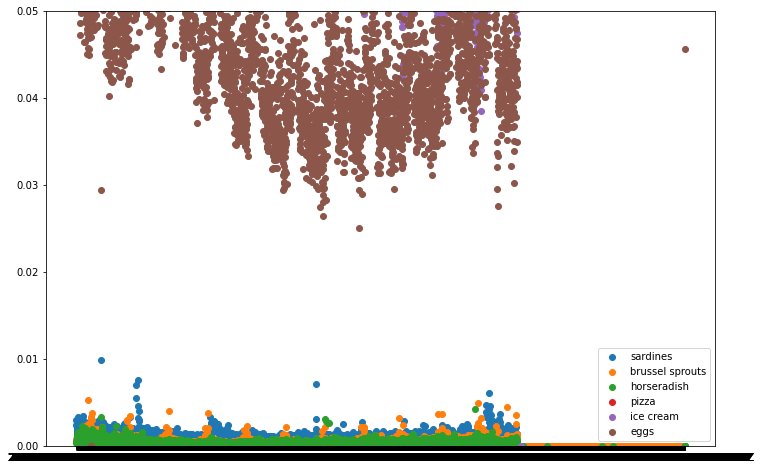

In [33]:
fig = plt.figure(figsize=(12,8))
 
for food in foods:
    plt.scatter(x=data[data['Food']==food].iloc[:,0],y=data[data['Food']==food].iloc[:,1],label=food)
    
plt.ylim(0,.05)
plt.legend()
plt.show()

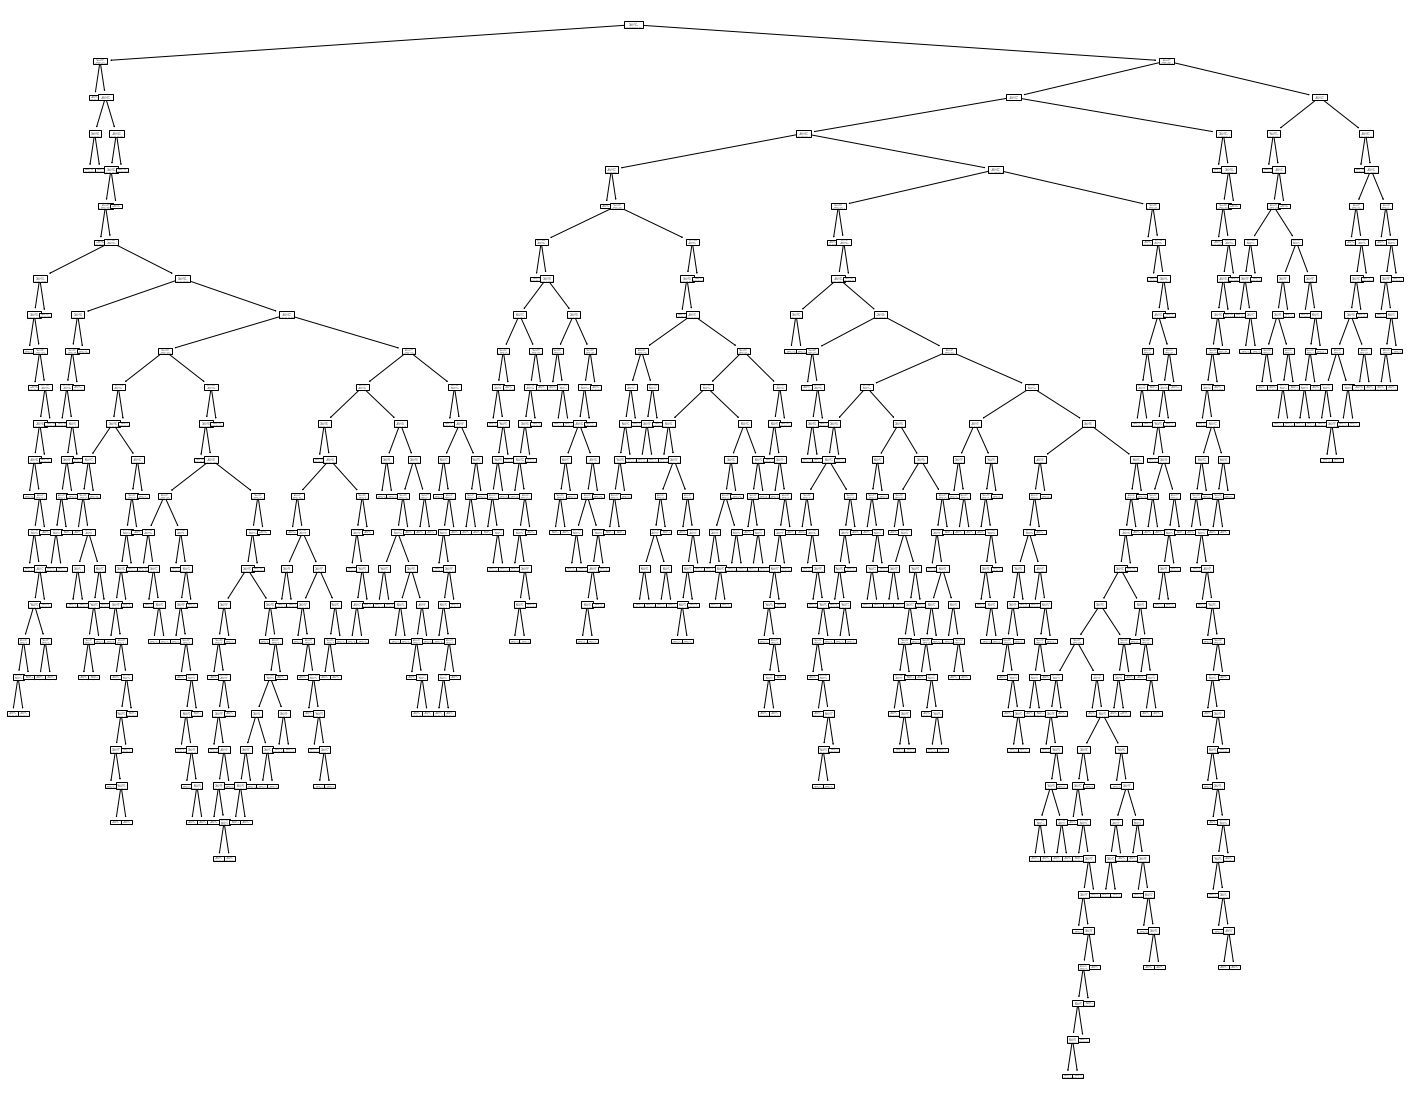

In [34]:
from sklearn import tree
fig = plt.figure(figsize=(25,20))
_ = tree.plot_tree(dtc)